In [145]:
# Render our plots inline
%matplotlib inline
%pylab inline  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# General Plotting Parameters
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 14.
mpl.rcParams['legend.fontsize'] = 12.
mpl.rcParams['axes.labelsize'] = 12.
mpl.rcParams['xtick.labelsize'] = 10.
mpl.rcParams['ytick.labelsize'] = 10.
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

#Git says this is patched, but it doesn't work from Pip --upgrade 26-mar-2015
#mpl.rcParams['xtick.minor.visible'] = True  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
             (255, 187, 120), (44, 160, 44), (152, 223, 138),
              (148, 103, 189),
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127),
             (199, 199, 199), (188, 189, 34), (219, 219, 141),
             (23, 190, 207), (158, 218, 229),(214, 39, 40), (255, 152, 150)]  
    
# Scale the RGB values to the [0, 1] range,
# which is the format matplotlib accepts.  
for i in range(len(tableau20)): 
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
plot_dir = './' 

ps = 1

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [146]:
import calc_enrich
reload(calc_enrich)
from calc_enrich import calc_del_U
from calc_enrich import Npc_from_Nstages
from calc_enrich import Nwc_from_Nstages
from calc_enrich import calc_feed_flows
from calc_enrich import find_N_stages
from calc_enrich import design_cascade

In [147]:
# centrifuge params 
#omega = 64000
#d = 0.1  # m 
#Z = 2.0   # m
#F_m_hrs = 70 # grams/hr  
#T = 320.0   # K
#cut = 0.5
eff = 1.0 # centrifuge efficiency

d = 0.15  # m 
Z = 1.0   # m
F_m_hrs = 15*60*60/(1e3) # grams/hr  
T = 320.0# K
cut = 0.5
omega = 485/(d/2)

# cascade params
Nfc = 0.007
Npc = 0.035
Nwc = 0.003
Fc_month = 739 #kg/month

# The feed enrichment to be used when using a cascade designed for LEU to produce HEU.
Nfc_mod = 0.20
Fc_month_mod = Fc_month #kg/month
#Fc_month_mod = 46 #kg/month

#unit conversions
kg_sec2kg_month = 30.4*24*60*60
v_a = omega * (d/2.0)
F_m = F_m_hrs/(60*60*1000.0)
Fc = Fc_month/kg_sec2kg_month
Fc_mod = Fc_month_mod/kg_sec2kg_month

# Comparison numbers (not needed for calculations)
del_U_th_yr = 1.1 #swu/yr
del_U_obs_yr = 0.71 #Swu/yr
del_U_th = del_U_th_yr/(365.25*24*60*60) #kgSWU/sec
del_U_obs = del_U_obs_yr/(365.25*24*60*60)

Pc_month = 77 #kg/month
Pc = Pc_month/kg_sec2kg_month

qty_len = 8
assay_len = 4

In [148]:
alpha, del_U, del_U_yr, dirac = calc_del_U(v_a, Z, d, F_m, T, cut, eff)

# Find the number of stages needed for enriching and stripping 
# (don't use the stages_per_cascade fn because it only works when alpha is close to 1)

ideal_enrich_stage, ideal_strip_stage = find_N_stages(alpha, Nfc, Npc, Nwc)
feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, Fc, cut)
all_stages, n_machines = design_cascade(cut, alpha, del_U, Nfc, feed_flows, ideal_enrich_stage, ideal_strip_stage,
                                        verbose=True, pretty=True, qty_len=qty_len)
print "total machines", n_machines


Stage   #Mach	 Feed    Product  Waste	 F_assay 	P_assay W_assay
0 	272 	3762.18    1881.09    1881.09    0.007 	0.0089 	0.0055
1 	233 	3224.73    1612.36    1612.36    0.0089 	0.0112 	0.007
2 	194 	2687.27    1343.64    1343.64    0.0112 	0.0142 	0.0089
3 	156 	2149.82    1074.91    1074.91    0.0142 	0.018 	0.0112
4 	117 	1612.36    806.18    806.18    0.018 	0.0228 	0.0142
5 	78 	1074.91    537.45    537.45    0.0228 	0.0287 	0.018
6 	39 	537.45    268.73    268.73    0.0287 	0.0362 	0.0228
-1 	204 	2821.64    1410.82    1410.82    0.0055 	0.007 	0.0044
-2 	136 	1881.09    940.55    940.55    0.0044 	0.0055 	0.0034
-3 	68 	940.55    470.27    470.27    0.0034 	0.0044 	0.0027
total machines 1497


In [149]:
del_U_yr, dirac

(6.0709128221690971, 12.969113590518578)

In [150]:
tot_flow = 0
p_last = 0
w_next = 0
for i in range(len(all_stages)):
    if (i == 0):
        p_last = 0
    else:
        p_last = all_stages[i-1][3]
    if (i == len(all_stages)-1):
        w_next = 0
    else:
        w_next = all_stages[i+1][4]
    # If on stage zero then add feed also
    if (i == (ideal_strip_stage)):
        tot_flow = p_last+w_next+Fc
    else:
        tot_flow =  p_last+w_next
    print "stage", i - ideal_strip_stage,"Predicted flow ", feed_flows[i]," actual flow ", tot_flow


stage -3 Predicted flow  0.000358090222399  actual flow  0.000358090222399
stage -2 Predicted flow  0.000716180444799  actual flow  0.000716180444799
stage -1 Predicted flow  0.0010742706672  actual flow  0.0010742706672
stage 0 Predicted flow  0.0014323608896  actual flow  0.0014323608896
stage 1 Predicted flow  0.00122773790537  actual flow  0.00122773790537
stage 2 Predicted flow  0.00102311492114  actual flow  0.00102311492114
stage 3 Predicted flow  0.000818491936913  actual flow  0.000818491936913
stage 4 Predicted flow  0.000613868952685  actual flow  0.000613868952685
stage 5 Predicted flow  0.000409245968456  actual flow  0.000409245968456
stage 6 Predicted flow  0.000204622984228  actual flow  0.000204622984228


In [151]:
## Check that mass is conserved in the cascade

final_w = all_stages[0][4]
final_p = all_stages[len(all_stages)-1][3]
#final_f = round(Fc,qty_len)
final_f = Fc

res = final_f - final_p - final_w
print "Casc. F (kg/s)  Casc. P\t\tCasc. W\t\t (P+W)/F"
print  final_f, "\t", final_p, "\t", final_w, "\t", (final_p+final_w)/final_f

Casc. F (kg/s)  Casc. P		Casc. W		 (P+W)/F
0.000281356603314 	0.000102311492114 	0.0001790451112 	1.0


In [152]:
## Determine cascade production rate for off-design use

Npc_mod = Npc_from_Nstages(alpha, Nfc_mod, ideal_enrich_stage)
Nwc_mod = Nwc_from_Nstages(alpha, Nfc_mod, ideal_strip_stage)

feed_flow_mod = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, Fc_mod, cut)

mod_stages, n_m = design_cascade(cut, alpha, del_U, Nfc_mod, feed_flow_mod, ideal_enrich_stage,
                                 ideal_strip_stage, verbose=True, pretty=True, qty_len=qty_len)


Stage   #Mach	 Feed    Product  Waste	 F_assay 	P_assay W_assay
0 	272 	3762.18    1881.09    1881.09    0.2 	0.241 	0.1645
1 	233 	3224.73    1612.36    1612.36    0.241 	0.2873 	0.2
2 	194 	2687.27    1343.64    1343.64    0.2873 	0.3386 	0.241
3 	156 	2149.82    1074.91    1074.91    0.3386 	0.394 	0.2873
4 	117 	1612.36    806.18    806.18    0.394 	0.4523 	0.3386
5 	78 	1074.91    537.45    537.45    0.4523 	0.5119 	0.394
6 	39 	537.45    268.73    268.73    0.5119 	0.5711 	0.4523
-1 	204 	2821.64    1410.82    1410.82    0.1645 	0.2 	0.1342
-2 	136 	1881.09    940.55    940.55    0.1342 	0.1645 	0.1088
-3 	68 	940.55    470.27    470.27    0.1088 	0.1342 	0.0877


In [153]:
## Design Cascade based on available number of centrifuges, determine max Fc
max_centrifuges = 100
curr_feed = Fc
optimal_feed = Fc
step_size = 1.2  # MUST be a number Greater than 1. 
step = 1
ideal_enrich_stage, ideal_strip_stage = find_N_stages(alpha, Nfc, Npc, Nwc)
feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, curr_feed, cut)
all_stages, n_centrifuges = design_cascade(cut, alpha, del_U, Nfc, feed_flows, ideal_enrich_stage, ideal_strip_stage)

optimum_number = False
neg_inc = False
pos_inc = False

if (n_centrifuges < max_centrifuges):
    pos_inc = True
    step = step_size
elif (n_centrifuges > max_centrifuges):
    neg_inc = True
    step = 1.0/step_size
else:
    optimum_number = True
ntries=0
print "step size is", step
while (optimum_number == False) and (ntries < 100):
    ntries+=1
    last_feed = curr_feed
    curr_feed *= step
    feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, curr_feed, cut)
    all_stages, n_centrifuges = design_cascade(cut, alpha, del_U, Nfc, feed_flows, ideal_enrich_stage, 
                                               ideal_strip_stage)
    print "curr try", ntries, "Tot mach", n_centrifuges, "# in last stage: ", all_stages[-1][1]
    if (all_stages[-1][1] < 1):
        print "not enough centrifuges to fill all stages"
        optimum_number = True
        optimal_feed = last_feed
    elif (neg_inc == True) and (n_centrifuges < max_centrifuges):
        optimum_number = True
        optimal_feed = curr_feed
        print "reduced flow to correct #", n_centrifuges
    elif (pos_inc == True) and (n_centrifuges > max_centrifuges):
        optimum_number = True
        optimal_feed = last_feed
        print "increased flow to correct #", n_centrifuges

final_feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, optimal_feed, cut)
final_stages, final_n_mach = design_cascade(cut, alpha, del_U, Nfc, final_feed_flows, 
                                            ideal_enrich_stage, ideal_strip_stage, verbose=True, pretty=True)
print "Cascade can process ", optimal_feed*kg_sec2kg_month, " kg/month"
print "Final total machines", final_n_mach
print final_stages[:][0]

step size is 0.833333333333
curr try 1 Tot mach 1249 # in last stage:  33
curr try 2 Tot mach 1041 # in last stage:  27
curr try 3 Tot mach 868 # in last stage:  23
curr try 4 Tot mach 725 # in last stage:  19
curr try 5 Tot mach 605 # in last stage:  16
curr try 6 Tot mach 502 # in last stage:  13
curr try 7 Tot mach 420 # in last stage:  11
curr try 8 Tot mach 355 # in last stage:  10
curr try 9 Tot mach 296 # in last stage:  8
curr try 10 Tot mach 245 # in last stage:  7
curr try 11 Tot mach 207 # in last stage:  6
curr try 12 Tot mach 173 # in last stage:  5
curr try 13 Tot mach 145 # in last stage:  4
curr try 14 Tot mach 124 # in last stage:  4
curr try 15 Tot mach 103 # in last stage:  3
curr try 16 Tot mach 87 # in last stage:  3
reduced flow to correct # 87
Stage   #Mach	 Feed    Product  Waste	 F_assay 	P_assay W_assay
0 	15 	203.49    101.74    101.74    0.007 	0.0089 	0.0055
1 	13 	174.42    87.21    87.21    0.0089 	0.0112 	0.007
2 	11 	145.35    72.67    72.67    0.0112 	

In [154]:
## A cascade with a fixed number of centrifuges has a maximum flow rate already defined
## This flow rate and production does not change with change to feed assay. Therefore the
## only things that change with a modified cascade are the product and waste assays

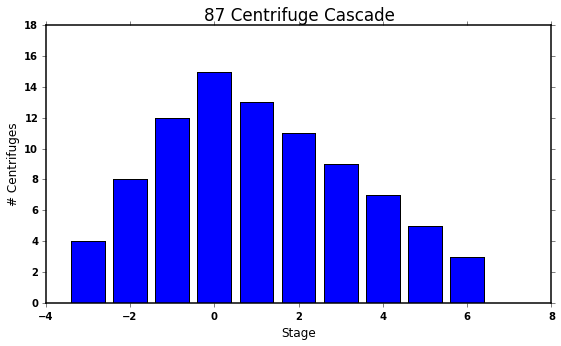

In [155]:
all_stages = []

for s in range(len(final_stages)):
    all_stages.append([final_stages[s][0],final_stages[s][1]])

fs = np.array(all_stages)
bar_width = 0.8
bar_res = plt.bar(fs[:,0]-0.4, fs[:,1], bar_width)

plt.xlabel('Stage')
plt.ylabel('# Centrifuges')
plt.title(str(int(final_n_mach)) + " Centrifuge Cascade")
plt.legend()
plt.ylim((0,1.2*fs[:,1].max()))
plt.tight_layout()

if ps == 1:
    savefig(plot_dir + 'cascade_design.png')

plt.show()
